## Neural network predicting 1 future point based on velocities

In [1]:
#! git clone https://github.com/crowdbotp/OpenTraj.git
#! pip install pykalman

In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.getcwd()) + '/OpenTraj/opentraj/') # Anaconda python can't find the toolkit path without this for some reason

from toolkit.loaders.loader_edinburgh import load_edinburgh
from matplotlib import pyplot as plt
import numpy as np
np.random.seed(42)

## Data preparation

In [14]:
opentraj_root = './OpenTraj/'
selected_day = '01Sep' # 3 days of data in total, ['01Jul', '01Aug', '01Sep']
edinburgh_path = os.path.join(opentraj_root, 'datasets/Edinburgh/annotations', 'tracks.%s.txt' % selected_day)
traj_dataset = load_edinburgh(edinburgh_path, title="Edinburgh", 
                              use_kalman=False, scene_id=selected_day, sampling_rate=9)

/Users/kriis/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


reading:./OpenTraj/datasets/Edinburgh/annotations/tracks.01Sep.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2342/2342 [01:02<00:00, 37.32it/s]


Warning! too big dt in [Edinburgh]
finish


In [15]:
data = traj_dataset.data
NUM_OF_STEPS = 5

# Removing any agents which don't have enough steps for model fitting and predicting
agent_ids = data.agent_id.unique()
for agent_id in agent_ids:
    if len(data[data.agent_id == agent_id]) < 2*NUM_OF_STEPS:
        data = data[data.agent_id != agent_id]
agent_ids = data.agent_id.unique()

In [16]:
# 'Normalize' the data so that all trajectories will begin at x=0, y=0
for agent_id in agent_ids:
    first_x = data[data.agent_id == agent_id]['pos_x'].iloc[0]
    first_y = data[data.agent_id == agent_id]['pos_y'].iloc[0]
    
    data.loc[data.agent_id == agent_id, 'pos_x'] = data[data.agent_id == agent_id]['pos_x'] - first_x
    data.loc[data.agent_id == agent_id, 'pos_y'] = data[data.agent_id == agent_id]['pos_y'] - first_y

In [17]:
# Select the useful columns from the dataset
data = data[['index', 'agent_id', 'pos_x', 'pos_y', 'vel_x', 'vel_y']]

In [18]:
from sklearn.model_selection import train_test_split
train_agent_ids, test_agent_ids = train_test_split(agent_ids, test_size=0.2)

### Helper functions

In [24]:
def create_dataset(data, agent_ids):
    dataX, dataY = [], []
    for agent_id in agent_ids:
        x = data[data['agent_id'] == agent_id].iloc[1:5][['vel_x', 'vel_y']]
        y = data[data['agent_id'] == agent_id].iloc[5][['vel_x', 'vel_y']]
        dataX.append(x)
        dataY.append(y)
    return np.array(dataX), np.array(dataY)
    
def calculate_error(pred_x, pred_y, test_x, test_y):
    
    # FDE
    final_displacement_x = pred_x[-1] - test_x[-1]
    final_displacement_y = pred_y[-1] - test_y[-1]
    FDE = np.sqrt(final_displacement_x**2 + final_displacement_y**2)
    
    # MSE
    abs_error_x = pred_x - test_x
    abs_error_y = pred_y - test_y
    
    MSE = np.mean(np.square(abs_error_x)) + np.mean(np.square(abs_error_y))
    
    return FDE, MSE

## Experiment

In [25]:
train = create_dataset(data, train_agent_ids)
test = create_dataset(data, test_agent_ids)

In [26]:
from keras.models import Model
from keras.layers import *    
from keras import backend as K

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

#inp = Input((5,2))
inp = Input((4,2))

x = Flatten()(inp)

x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(16, activation='relu')(x)

out1 = Dense(1, activation='linear')(x)    
out2 = Dense(1, activation='linear')(x)

model = Model(inputs=inp, outputs=[out1,out2])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss = RMSE)

In [27]:
sep_y_train_data = np.hsplit(train[1], 2) # separate the y data into pieces to only provide 1 point as NN output
model.fit(train[0], [sep_y_train_data[0], sep_y_train_data[1]], epochs=400, batch_size=16, verbose=2)

Epoch 1/400


2022-01-13 16:46:03.818800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


39/39 - 1s - loss: 1.2033 - dense_16_loss: 0.6897 - dense_17_loss: 0.5136 - 537ms/epoch - 14ms/step
Epoch 2/400
39/39 - 0s - loss: 0.7288 - dense_16_loss: 0.3774 - dense_17_loss: 0.3514 - 196ms/epoch - 5ms/step
Epoch 3/400
39/39 - 0s - loss: 0.6497 - dense_16_loss: 0.3168 - dense_17_loss: 0.3329 - 197ms/epoch - 5ms/step
Epoch 4/400
39/39 - 0s - loss: 0.5960 - dense_16_loss: 0.2772 - dense_17_loss: 0.3188 - 207ms/epoch - 5ms/step
Epoch 5/400
39/39 - 0s - loss: 0.5879 - dense_16_loss: 0.2734 - dense_17_loss: 0.3145 - 196ms/epoch - 5ms/step
Epoch 6/400
39/39 - 0s - loss: 0.5848 - dense_16_loss: 0.2741 - dense_17_loss: 0.3107 - 196ms/epoch - 5ms/step
Epoch 7/400
39/39 - 0s - loss: 0.5686 - dense_16_loss: 0.2669 - dense_17_loss: 0.3017 - 195ms/epoch - 5ms/step
Epoch 8/400
39/39 - 0s - loss: 0.5614 - dense_16_loss: 0.2575 - dense_17_loss: 0.3039 - 196ms/epoch - 5ms/step
Epoch 9/400
39/39 - 0s - loss: 0.5413 - dense_16_loss: 0.2468 - dense_17_loss: 0.2945 - 194ms/epoch - 5ms/step
Epoch 10/400

Epoch 75/400
39/39 - 0s - loss: 0.3659 - dense_16_loss: 0.1871 - dense_17_loss: 0.1788 - 193ms/epoch - 5ms/step
Epoch 76/400
39/39 - 0s - loss: 0.3595 - dense_16_loss: 0.1859 - dense_17_loss: 0.1736 - 195ms/epoch - 5ms/step
Epoch 77/400
39/39 - 0s - loss: 0.3577 - dense_16_loss: 0.1834 - dense_17_loss: 0.1743 - 193ms/epoch - 5ms/step
Epoch 78/400
39/39 - 0s - loss: 0.3607 - dense_16_loss: 0.1839 - dense_17_loss: 0.1768 - 192ms/epoch - 5ms/step
Epoch 79/400
39/39 - 0s - loss: 0.3542 - dense_16_loss: 0.1820 - dense_17_loss: 0.1722 - 193ms/epoch - 5ms/step
Epoch 80/400
39/39 - 0s - loss: 0.3622 - dense_16_loss: 0.1905 - dense_17_loss: 0.1718 - 199ms/epoch - 5ms/step
Epoch 81/400
39/39 - 0s - loss: 0.3558 - dense_16_loss: 0.1841 - dense_17_loss: 0.1717 - 197ms/epoch - 5ms/step
Epoch 82/400
39/39 - 0s - loss: 0.3627 - dense_16_loss: 0.1907 - dense_17_loss: 0.1720 - 191ms/epoch - 5ms/step
Epoch 83/400
39/39 - 0s - loss: 0.3552 - dense_16_loss: 0.1848 - dense_17_loss: 0.1704 - 191ms/epoch - 5

Epoch 148/400
39/39 - 0s - loss: 0.2884 - dense_16_loss: 0.1564 - dense_17_loss: 0.1320 - 200ms/epoch - 5ms/step
Epoch 149/400
39/39 - 0s - loss: 0.3001 - dense_16_loss: 0.1636 - dense_17_loss: 0.1365 - 196ms/epoch - 5ms/step
Epoch 150/400
39/39 - 0s - loss: 0.2867 - dense_16_loss: 0.1516 - dense_17_loss: 0.1351 - 194ms/epoch - 5ms/step
Epoch 151/400
39/39 - 0s - loss: 0.2863 - dense_16_loss: 0.1523 - dense_17_loss: 0.1340 - 197ms/epoch - 5ms/step
Epoch 152/400
39/39 - 0s - loss: 0.2850 - dense_16_loss: 0.1533 - dense_17_loss: 0.1317 - 196ms/epoch - 5ms/step
Epoch 153/400
39/39 - 0s - loss: 0.2838 - dense_16_loss: 0.1534 - dense_17_loss: 0.1304 - 196ms/epoch - 5ms/step
Epoch 154/400
39/39 - 0s - loss: 0.2855 - dense_16_loss: 0.1495 - dense_17_loss: 0.1360 - 197ms/epoch - 5ms/step
Epoch 155/400
39/39 - 0s - loss: 0.2925 - dense_16_loss: 0.1528 - dense_17_loss: 0.1397 - 195ms/epoch - 5ms/step
Epoch 156/400
39/39 - 0s - loss: 0.2947 - dense_16_loss: 0.1526 - dense_17_loss: 0.1422 - 196ms/

Epoch 221/400
39/39 - 0s - loss: 0.2576 - dense_16_loss: 0.1389 - dense_17_loss: 0.1187 - 195ms/epoch - 5ms/step
Epoch 222/400
39/39 - 0s - loss: 0.2471 - dense_16_loss: 0.1314 - dense_17_loss: 0.1158 - 195ms/epoch - 5ms/step
Epoch 223/400
39/39 - 0s - loss: 0.2480 - dense_16_loss: 0.1346 - dense_17_loss: 0.1133 - 193ms/epoch - 5ms/step
Epoch 224/400
39/39 - 0s - loss: 0.2479 - dense_16_loss: 0.1293 - dense_17_loss: 0.1186 - 193ms/epoch - 5ms/step
Epoch 225/400
39/39 - 0s - loss: 0.2564 - dense_16_loss: 0.1363 - dense_17_loss: 0.1200 - 195ms/epoch - 5ms/step
Epoch 226/400
39/39 - 0s - loss: 0.2485 - dense_16_loss: 0.1338 - dense_17_loss: 0.1146 - 197ms/epoch - 5ms/step
Epoch 227/400
39/39 - 0s - loss: 0.2489 - dense_16_loss: 0.1297 - dense_17_loss: 0.1192 - 193ms/epoch - 5ms/step
Epoch 228/400
39/39 - 0s - loss: 0.2561 - dense_16_loss: 0.1358 - dense_17_loss: 0.1202 - 191ms/epoch - 5ms/step
Epoch 229/400
39/39 - 0s - loss: 0.2578 - dense_16_loss: 0.1386 - dense_17_loss: 0.1193 - 190ms/

Epoch 294/400
39/39 - 0s - loss: 0.2233 - dense_16_loss: 0.1178 - dense_17_loss: 0.1054 - 194ms/epoch - 5ms/step
Epoch 295/400
39/39 - 0s - loss: 0.2192 - dense_16_loss: 0.1133 - dense_17_loss: 0.1060 - 194ms/epoch - 5ms/step
Epoch 296/400
39/39 - 0s - loss: 0.2241 - dense_16_loss: 0.1201 - dense_17_loss: 0.1040 - 196ms/epoch - 5ms/step
Epoch 297/400
39/39 - 0s - loss: 0.2350 - dense_16_loss: 0.1183 - dense_17_loss: 0.1167 - 192ms/epoch - 5ms/step
Epoch 298/400
39/39 - 0s - loss: 0.2256 - dense_16_loss: 0.1172 - dense_17_loss: 0.1085 - 195ms/epoch - 5ms/step
Epoch 299/400
39/39 - 0s - loss: 0.2172 - dense_16_loss: 0.1147 - dense_17_loss: 0.1025 - 195ms/epoch - 5ms/step
Epoch 300/400
39/39 - 0s - loss: 0.2253 - dense_16_loss: 0.1224 - dense_17_loss: 0.1029 - 197ms/epoch - 5ms/step
Epoch 301/400
39/39 - 0s - loss: 0.2152 - dense_16_loss: 0.1175 - dense_17_loss: 0.0977 - 198ms/epoch - 5ms/step
Epoch 302/400
39/39 - 0s - loss: 0.2252 - dense_16_loss: 0.1219 - dense_17_loss: 0.1033 - 197ms/

Epoch 367/400
39/39 - 0s - loss: 0.2162 - dense_16_loss: 0.1153 - dense_17_loss: 0.1009 - 191ms/epoch - 5ms/step
Epoch 368/400
39/39 - 0s - loss: 0.2044 - dense_16_loss: 0.1068 - dense_17_loss: 0.0976 - 201ms/epoch - 5ms/step
Epoch 369/400
39/39 - 0s - loss: 0.2061 - dense_16_loss: 0.1061 - dense_17_loss: 0.1000 - 196ms/epoch - 5ms/step
Epoch 370/400
39/39 - 0s - loss: 0.2117 - dense_16_loss: 0.1068 - dense_17_loss: 0.1049 - 193ms/epoch - 5ms/step
Epoch 371/400
39/39 - 0s - loss: 0.1993 - dense_16_loss: 0.1043 - dense_17_loss: 0.0950 - 197ms/epoch - 5ms/step
Epoch 372/400
39/39 - 0s - loss: 0.2061 - dense_16_loss: 0.1099 - dense_17_loss: 0.0962 - 199ms/epoch - 5ms/step
Epoch 373/400
39/39 - 0s - loss: 0.2118 - dense_16_loss: 0.1153 - dense_17_loss: 0.0965 - 193ms/epoch - 5ms/step
Epoch 374/400
39/39 - 0s - loss: 0.2095 - dense_16_loss: 0.1095 - dense_17_loss: 0.1000 - 192ms/epoch - 5ms/step
Epoch 375/400
39/39 - 0s - loss: 0.1985 - dense_16_loss: 0.1021 - dense_17_loss: 0.0964 - 196ms/

In [28]:
trainScore = model.evaluate(train[0], [sep_y_train_data[0], sep_y_train_data[1]], verbose=0)
print('Train Score: %.2f' % (trainScore[0]))

sep_y_test_data = np.hsplit(test[1], 2)
testScore = model.evaluate(test[0], [sep_y_test_data[0], sep_y_test_data[1]], verbose=0)
print('Test Score: %.2f' % (testScore[0]))

Train Score: 0.22
Test Score: 0.85


2022-01-13 16:47:25.098134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


## Predicting on train data and plotting

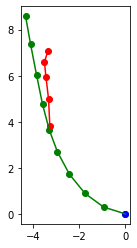

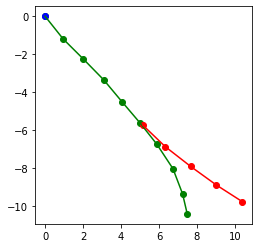

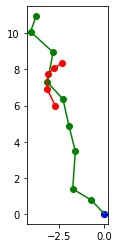

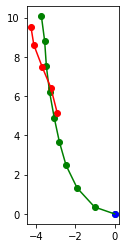

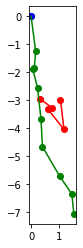

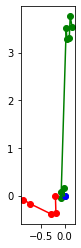

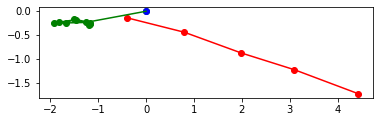

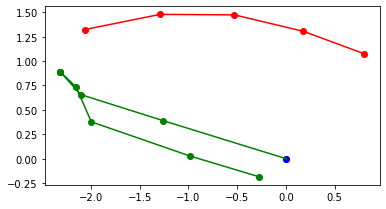

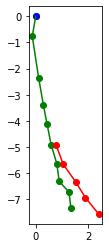

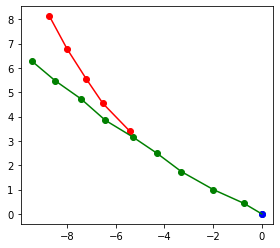

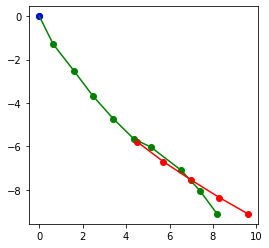

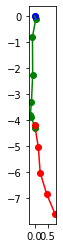

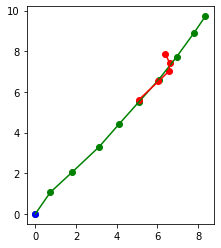

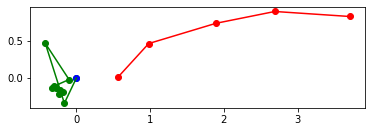

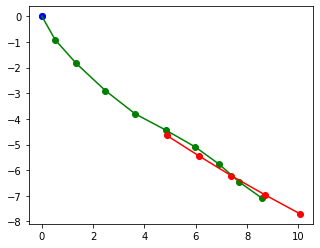

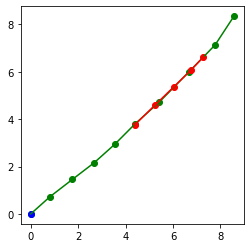

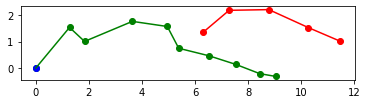

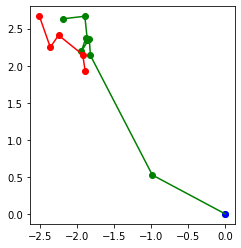

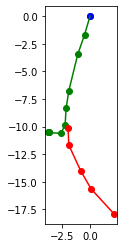

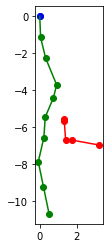

Average FDE:  2.5988962964539564


In [36]:
# Creating a 'rolling' prediction, predicting 1 point based on 5 seen points, then another point based
# on 4 seen points and 1 predicted point and so on
all_FDE = []
plotting = True
no_of_plotted_trajectories = 20

for idx, agent_id in enumerate(test_agent_ids):

    seen_x = np.array(data[data['agent_id'] == agent_id].iloc[:5]['pos_x'])
    seen_y = np.array(data[data['agent_id'] == agent_id].iloc[:5]['pos_y'])
    
    seen_vel_x = np.array(data[data['agent_id'] == agent_id].iloc[1:5]['vel_x'])
    seen_vel_y = np.array(data[data['agent_id'] == agent_id].iloc[1:5]['vel_y'])
    
    unseen_x = np.array(data[data['agent_id'] == agent_id].iloc[5:10]['pos_x'])
    unseen_y = np.array(data[data['agent_id'] == agent_id].iloc[5:10]['pos_y'])

    rolling_vel_x = np.array(seen_vel_x)
    rolling_vel_y = np.array(seen_vel_y)
    for i in range(5):
        seen_velocities = np.column_stack((rolling_vel_x, rolling_vel_y))
        pred_vel_x, pred_vel_y = model.predict(np.array([seen_velocities]))

        # To get the fifth velocity we need for prediction
        if i == 4:
            rolling_vel_x = np.append(rolling_vel_x, [pred_vel_x[0]])
            rolling_vel_y = np.append(rolling_vel_y, [pred_vel_y[0]])
        else:
            rolling_vel_x = np.append(rolling_vel_x[1:], [pred_vel_x[0]])
            rolling_vel_y = np.append(rolling_vel_y[1:], [pred_vel_y[0]])

    # Create coordinates from the velocity predictions
    pred_coord_x = [seen_x[-1] + rolling_vel_x[0]]
    pred_coord_y = [seen_y[-1] + rolling_vel_y[0]]
    for i in range(1, 5):
        pred_coord_x.append(pred_coord_x[i-1] + rolling_vel_x[i])
        pred_coord_y.append(pred_coord_y[i-1] + rolling_vel_y[i])
        
    # Calculate final displacement error
    FDE = np.sqrt((pred_coord_x[-1] - unseen_x[-1])**2 + (pred_coord_y[-1] - unseen_y[-1])**2)
    all_FDE.append(FDE)
    
    # plot data
    if plotting and idx < no_of_plotted_trajectories:
        plt.axes().set_aspect('equal')

        plt.plot(np.append(seen_x, unseen_x), np.append(seen_y, unseen_y), color='g')
        plt.scatter(np.append(seen_x, unseen_x), np.append(seen_y, unseen_y), color='g')

        plt.plot(pred_coord_x, pred_coord_y, color='r')
        plt.scatter(pred_coord_x, pred_coord_y, color='r')

        plt.scatter(seen_x[0], seen_y[0], color='b')

        plt.show()

print("Average FDE: ", np.mean(all_FDE))